In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.efficientnetv2 import EfficientNetV2
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/efficientnetv2")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

35


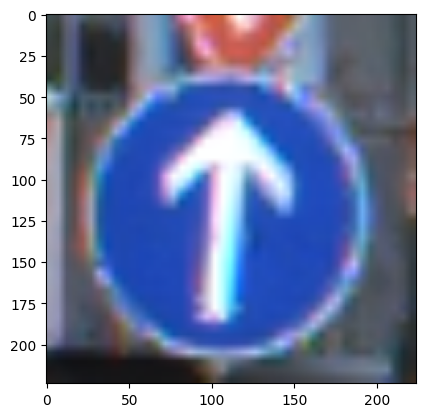

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = EfficientNetV2(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
EfficientNetV2                                                    --
├─Conv2dNormActivation: 1-1                                       --
│    └─Conv2d: 2-1                                                648
│    └─BatchNorm2d: 2-2                                           48
│    └─SiLU: 2-3                                                  --
├─Sequential: 1-2                                                 --
│    └─InvertedResidualBlock: 2-4                                 --
│    │    └─ResBlock: 3-1                                         10,464
│    └─InvertedResidualBlock: 2-5                                 --
│    │    └─ResBlock: 3-2                                         10,464
│    └─InvertedResidualBlock: 2-6                                 --
│    │    └─FusedMBConv: 3-3                                      62,496
│    └─InvertedResidualBlock: 2-7                                 --
│    │    └─ResB

# training

In [13]:
epochs = 10

In [14]:
trainer = ClassificationTrainer(epochs, device)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 832/832 [02:20<00:00,  5.94it/s]


epoch 1 : 0.07008064552568473 (0%)


100%|██████████| 832/832 [02:05<00:00,  6.61it/s]


epoch 2 : 0.045066150003829256 (-36%)


100%|██████████| 832/832 [02:05<00:00,  6.62it/s]


epoch 3 : 0.01987922304257294 (-56%)


100%|██████████| 832/832 [02:07<00:00,  6.51it/s]


epoch 4 : 0.0091268903035178 (-54%)


100%|██████████| 832/832 [02:19<00:00,  5.98it/s]


epoch 5 : 0.005873639345981456 (-36%)


100%|██████████| 832/832 [02:09<00:00,  6.41it/s]


epoch 6 : 0.004093558787207467 (-30%)


100%|██████████| 832/832 [02:11<00:00,  6.33it/s]


epoch 7 : 0.0036346854823250396 (-11%)


100%|██████████| 832/832 [02:06<00:00,  6.57it/s]


epoch 8 : 0.003081663148984367 (-15%)


100%|██████████| 832/832 [02:04<00:00,  6.67it/s]


epoch 9 : 0.0029054162936815306 (-6%)


100%|██████████| 832/832 [02:06<00:00,  6.59it/s]

epoch 10 : 0.001997694884331316 (-31%)


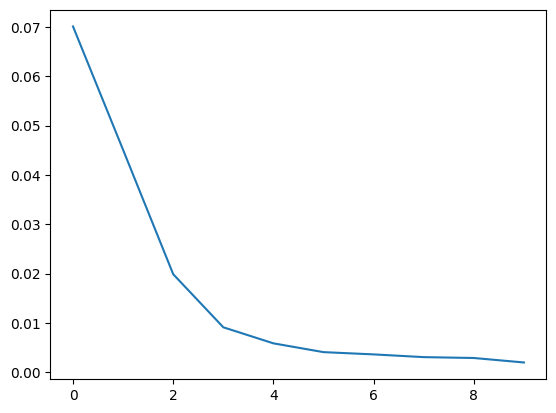

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(num_class, device)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 395/395 [00:29<00:00, 13.17it/s]

[[ 59   1   0 ...   0   0   0]
 [  1 700   3 ...   0   0   0]
 [  0   4 693 ...   0   0   0]
 ...
 [  0   0   0 ...  81   0   0]
 [  0   0   0 ...   0  55   0]
 [  0   0   0 ...   0   4  81]]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.9833333333333333
1         : 0.9722222222222222
2         : 0.924
3         : 0.9822222222222222
4         : 0.9409090909090909
5         : 0.9666666666666667
6         : 0.8466666666666667
7         : 0.7866666666666666
8         : 0.9822222222222222
9         : 0.9979166666666667
10        : 0.946969696969697
11        : 0.9285714285714286
12        : 0.9101449275362319
13        : 0.9819444444444444
14        : 0.9814814814814815
15        : 0.9952380952380953
16        : 0.9666666666666667
17        : 0.8944444444444445
18        : 0.7974358974358975
19        : 0.8833333333333333
20        : 0.5666666666666667
21        : 0.5555555555555556
22        : 0.8416666666666667
23        : 0.7333333333333333
24        : 0.7333333333333333
25        : 0.9604166666666667
26        : 0.9333333333333333
27        : 0.5
28        : 0.9466666666666667
29        : 0.9777777777777777
30        : 0.64
31        : 0.9222222222222223
32        : 0.9833333333333333
33        : 0.790476

In [24]:
per_class_acc.mean()

0.8629041494213385

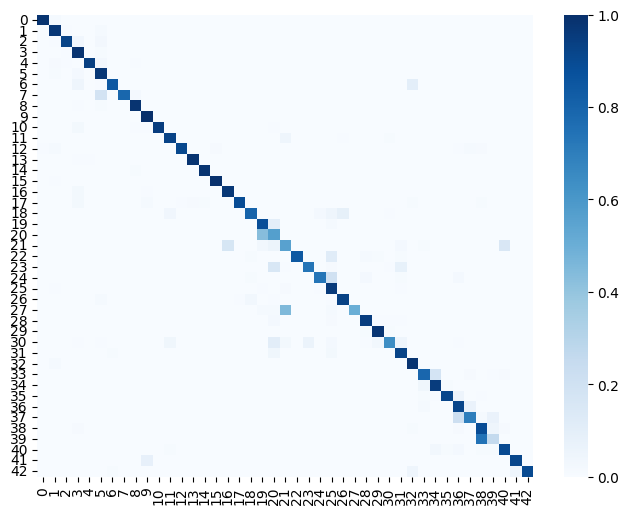

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'efficientnetv2.s.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'80.75MiB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>